## Image-to-Image (I2I) Network Demo Notebook

In this notebook we show how STUN, UNet, and ViT are trained and evaluated on non-stationary, spatial data. This notebook is intended to be a tutorial/demonstration. 

In [1]:
import torch
from torch.utils.data import DataLoader

import time

# directly import from latticevision library in directory
from latticevision.device import set_device
from latticevision.img2img.dataset import (
	make_dataset,
	DataConfig,
	no_transform,
	polar_transform,
)
from latticevision.plotting import plot_example_field, plot_losses, plot_img2img_samples
from latticevision.img2img import TransUNet, UNet, ViT
from latticevision.img2img.base import (
	ModelConfig,
	NullPosEmbed,
	LearnedPosEmbed,
	SinusoidalPosEmbed,
	RotaryPosEmbed,
)
from latticevision.img2img.train import train_model, TrainingConfig
from latticevision.img2img.eval import eval_model
from latticevision.seed import set_all_random_seeds

The `set_device` function from `device.py` is used to set the device based on whether you are running this work locally or on a remote server with named GPUs. 

In [2]:
# set random seed for reproducibility
set_all_random_seeds(777)

# for remote use
device = set_device(machine="remote", gpu=True, gpu_id="cuda:0", verbose=True)

# for local use
# device = set_device(machine="local", gpu=True, verbose=True)

Using device: cuda:0 
Hardware:  NVIDIA RTX A6000


The `make_dataset` function from `dataset.py` returns the extracted fields, awghts, and configs from the hdf5 file, and creates our train, val, and test datasets for us. 

In [5]:
# for testing
dataset_path = "../data/I2I_sample_data.h5"
val_size = 0.4
test_size = 0.5

# dataset_path = "../data/I2I_data.h5"
# val_size = 0.1
# test_size = 0.2

transform_funcs = [no_transform, polar_transform]

data_config = DataConfig(
	file_path=dataset_path,
	n_rows=192,
	n_cols=288,
	n_replicates=30,
	n_params=3,
	transform_function=transform_funcs[0],
	log_kappa2=True,
	shift_theta=True,
	val_size=val_size,
	test_size=test_size,
	random_state=777,
	verbose=True,
)

data_dict = make_dataset(
	config=data_config,
)

train_df = data_dict["train_df"]
val_df = data_dict["val_df"]
test_df = data_dict["test_df"]

Components in the file: ['fields']
Dataset size (MB):  69.60951232910156
Dataset size (GB):  0.06797803938388824
Fields shape:  (5, 30, 192, 288)
Params shape:  (5, 3, 192, 288)
Train fields shape:  (3, 30, 192, 288)
Train params shape:  (3, 3, 192, 288)
Validation fields shape:  (1, 30, 192, 288)
Validation params shape:  (1, 3, 192, 288)
Test fields shape:  (1, 30, 192, 288)
Test params shape:  (1, 3, 192, 288)


Let's plot an example field using the `plot_example_field` function from `plotting.py`.

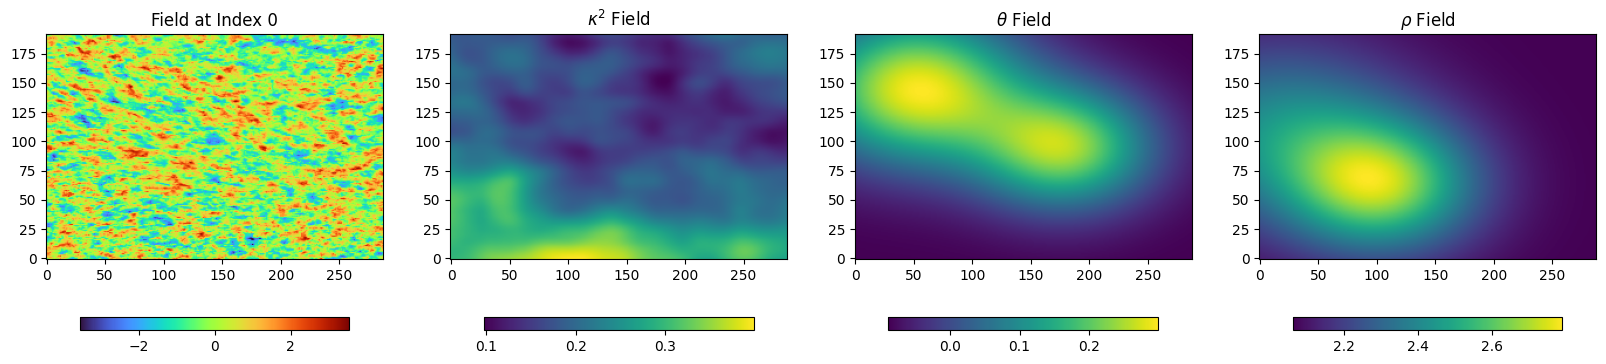

In [6]:
plot_example_field(
	dataset=train_df,
	config=data_config,
	idx=0,
	model_type="STUN",
	field_color="turbo",
	param1_color="viridis",
	param2_color="viridis",
	param3_color="viridis",
)

## Training

We now use the `DataLoader` class from PyTorch to conveniently batch the data. 

In [7]:
# n_batch = 64
n_batch = 2

train_loader = DataLoader(train_df, batch_size=n_batch, shuffle=True)
val_loader = DataLoader(val_df, batch_size=n_batch, shuffle=False)
test_loader = DataLoader(test_df, batch_size=n_batch, shuffle=False)

for fields, params in train_loader:
	print("Train Loader:")
	print(
		"Fields batch shape: ",
		fields.shape,
		"\nParams batch shape: ",
		params.shape,
	)
	break

for fields, params in val_loader:
	print("Val Loader:")
	print(
		"Fields batch shape: ",
		fields.shape,
		"\nParams batch shape: ",
		params.shape,
	)
	break

for fields, params in test_loader:
	print("Test Loader:")
	print(
		"Fields batch shape: ",
		fields.shape,
		"\nParams batch shape: ",
		params.shape,
	)
	break

Train Loader:
Fields batch shape:  torch.Size([2, 30, 192, 288]) 
Params batch shape:  torch.Size([2, 3, 192, 288])
Val Loader:
Fields batch shape:  torch.Size([1, 30, 192, 288]) 
Params batch shape:  torch.Size([1, 3, 192, 288])
Test Loader:
Fields batch shape:  torch.Size([1, 30, 192, 288]) 
Params batch shape:  torch.Size([1, 3, 192, 288])


Now let's pull in our `TransUNet (STUN)`, `UNet`, or `ViT` from `stun.py`, `unet.py`, and `vit.py` respectively. We access all of these through the `__init__.py` file in the `img2img` folder.  

In [8]:
modeltype = "TransUNet"  # can also be "TransUNet, "ViT"

pos_embeds = [NullPosEmbed, LearnedPosEmbed, SinusoidalPosEmbed, RotaryPosEmbed]

if modeltype == "UNet":
	config = ModelConfig()
	model = UNet(config)
elif modeltype == "TransUNet":
	config = ModelConfig(
		patch_size_h=2,
		patch_size_w=2,
		pos_embed_cls=pos_embeds[3],
	)
	model = TransUNet(config)
elif modeltype == "ViT":
	config = ModelConfig(
		patch_size_h=16,
		patch_size_w=16,
		pos_embed_cls=pos_embeds[3],
	)
	model = ViT(config)
else:
	raise ValueError("modeltype must be one of 'UNet', 'TransUNet', or 'ViT'")

# send model to device and count params
model = model.to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 105325827


We train our model using `train_model` from `train.py`.

In [9]:
start_time = time.time()

train_config = TrainingConfig(
	model=model,
	device=device,
	train_loader=train_loader,
	val_loader=val_loader,
	train_df=train_df,
	val_df=val_df,
	lr=1e-4,
	n_epochs=3,
	stop_patience=10,
	scheduler_patience=5,
	scheduler_factor=0.5,
	augmentation=True,
	save=False,  # switch to True to save model after training, currently this is just training for show
	save_directory="results/model_wghts/",
	savename="stun_wghts_example.pth",
	verbose=True,
	normalize=True,
	shuffle=True,
)


training_results = train_model(config=train_config)

time_train = time.time() - start_time
print("Training took: ", time_train / 60, " minutes.")

model = training_results["model"]
train_losses = training_results["train_losses"]
baseline_losses = training_results["baseline_losses"]
val_losses = training_results["val_losses"]

Training for 3 epochs with learning rate 0.0001.
Model weights will not be saved.
Augmentation has been enabled.
Normalization has been enabled.
Shuffling has been enabled.
Epoch 1/3
Train Loss: 18.392266 - Base (Mean) Loss: 0.339411 - Val Loss: 7.028646
Learning Rate: 0.000100
Epoch 2/3
Train Loss: 14.645576 - Base (Mean) Loss: 0.339411 - Val Loss: 5.574002
Learning Rate: 0.000100
Epoch 3/3
Train Loss: 12.871477 - Base (Mean) Loss: 0.339411 - Val Loss: 4.804334
Learning Rate: 0.000100
Training complete. Best model weights loaded.
Training took:  0.08235507408777873  minutes.


Let's take a look at the loss with `plot_losses`, another function from `plotting.py` which should work for both the CNN and I2I models. 

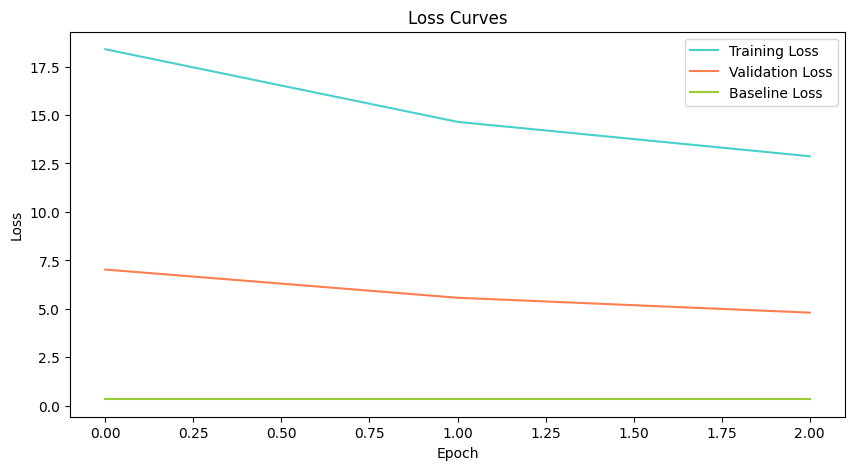

In [10]:
plot_losses(
	train_losses=train_losses,
	val_losses=val_losses,
	base_losses=baseline_losses,
	show=True,
)

The `train_model` function saves the model in `results/model_wghts/` if `save = True`. 

## Evaluation

If we want to load it back up again, **we run everything in the notebook except the two cells in which the training loop and loss plotting code are executed**. Then we continue on through the notebook, beginning with loading the model by using the code below: 

In [ ]:
modeltype = "TransUNet"  # can also be "UNet, "ViT"
modelpath = "../results/model_wghts/modelTransUNet_reps30_posRotaryPosEmbed.pth"
n_reps = 30
pos_embeds = [NullPosEmbed, LearnedPosEmbed, SinusoidalPosEmbed, RotaryPosEmbed]

if modeltype == "UNet":
	config = ModelConfig(
		in_channels=n_reps,
	)
	model = UNet(config)
	model.load_state_dict(torch.load(modelpath))

elif modeltype == "TransUNet":
	config = ModelConfig(
		in_channels=n_reps,
		patch_size_h=2,
		patch_size_w=2,
		pos_embed_cls=pos_embeds[3],
	)
	model = TransUNet(config)
	model.load_state_dict(torch.load(modelpath))
elif modeltype == "ViT":
	config = ModelConfig(
		in_channels=n_reps,
		patch_size_h=16,
		patch_size_w=16,
		pos_embed_cls=pos_embeds[3],
	)
	model = ViT(config)
	model.load_state_dict(torch.load(modelpath))
else:
	raise ValueError("modeltype must be one of 'UNet', 'TransUNet', or 'ViT'")

model = model.to(device)
model.eval()

TransUNet(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(30, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(8, 64, eps=1e-05, affine=True)
        (5): GELU(approximate='none')
      )
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1): EncoderBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(16, 128, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(16, 128, eps=1e-05, affine=True)
        (5): GELU(approximate='none')
      )
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2

This `eval_model` function from `eval.py` calculates a number of metrics and does some plotting. 

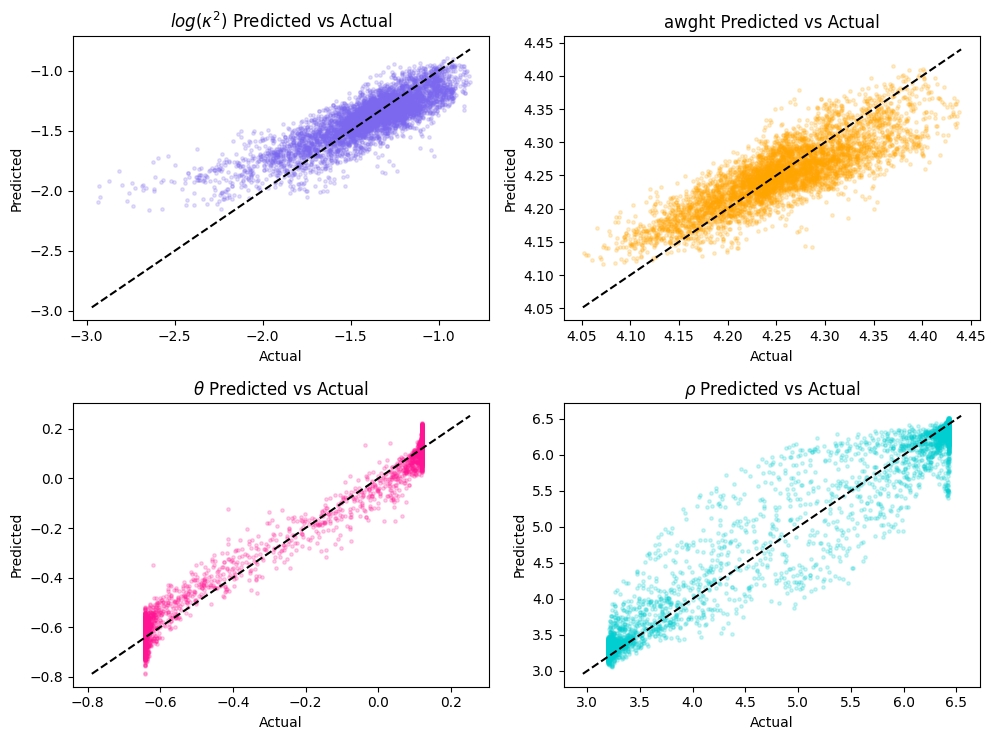

               rmse       mae        r2      ssim       psnr     nrmse
parameter                                                             
kappa2     0.165857  0.126560  0.694018  0.694390  22.252727  0.077155
theta      0.045169  0.035297  0.984631  0.697569  24.568942  0.059095
rho        0.287495  0.180274  0.960370  0.827509  21.009078  0.089032


In [12]:
metrics = eval_model(
	model=model,
	config=data_config,
	device=device,
	test_loader=test_loader,
	test_df=test_df,
	plot=True,
	augmentation=False,
	n_pixels=5000,
	show=True,
)

Here we take a couple fields inside of the test data and plot how the model does using `plot_img2img_samples` from `plotting.py`.

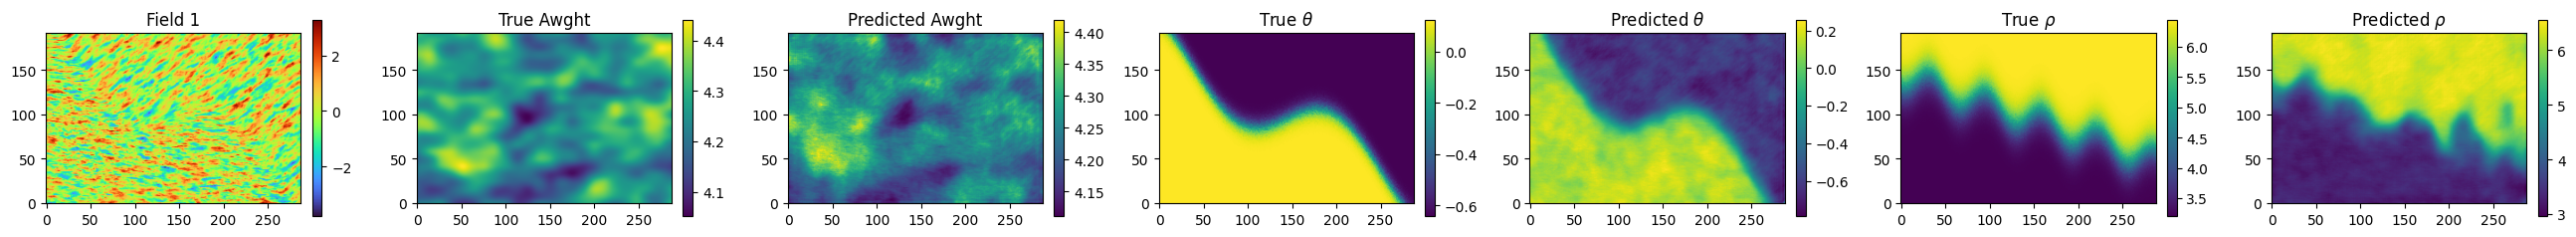

In [13]:
# inds = [0, 9, 16, 32, 37]
inds = [0] # for test dataset

plot_img2img_samples(
	model=model,
	config=data_config,
	device=device,
	test_df=test_df,
	indices=inds,
	random_selection=False,
	num_rand_samples=5,
	awght_not_kappa2=True,
	show=True,
)